In [1]:
import os
import sys
from shutil import copyfile
import json
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

# add parent directory of project to system path, to access all the packages in project, sys.path.append appends are not permanent
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('train.py')))))))

from src.model.VAEGAN.Encoder import Encoder 
from src.model.VAEGAN.Generator import Generator
from src.model.VAEGAN.Discriminator import Discriminator
from src.model.VAEGAN.UnsupervisedDiscriminator import UnsupervisedDiscriminator
from src.model.VAEGAN.SupervisedDiscriminator import SupervisedDiscriminator
from src.model.VAEGAN.VAEGAN import VAEGAN
from src.model.VAEGAN.dark_energy.GANMonitor import GANMonitor

readlines = ""
with open('Params.json') as file:
    readlines = file.read() 

Params = json.loads(readlines) 
latent_dim = Params['latent_dim'] 
epochs = Params['epochs']
patience = Params['patience']
lr_gen = Params['lr_gen']
beta_1_gen = Params['beta_1_gen']
lr_disc = Params['lr_disc']
beta_1_disc= Params['beta_1_disc']
batch_size = Params['batch_size']
input_dim = Params['input_dim']
output_dim = Params['output_dim']
n_classes = Params['n_classes']
train_size = Params['train_size']
buffer_size = train_size 
outdir = Params['outdir'] 

if not os.path.isdir(outdir):
    os.makedirs(outdir)
if not os.path.isdir(os.path.join(outdir, 'fig')):
    os.mkdir(os.path.join(outdir, 'fig')) 
if not os.path.isdir(os.path.join(outdir, 'ckpt')):
    os.mkdir(os.path.join(outdir, 'ckpt'))
if not os.path.isdir(os.path.join(outdir, 'log')):
    os.mkdir(os.path.join(outdir, 'log'))

copyfile('Params.json',os.path.join(outdir, 'Params.json'))

z = np.genfromtxt('../../../data/dark_energy_models/z.csv', dtype=np.float32)
x_real_580 = np.genfromtxt('../../../data/dark_energy_models/x_real_580_with_err.csv')

x_real = np.genfromtxt('../../../data/dark_energy_models/x_real.csv', dtype=np.float32)
y_real = np.genfromtxt('../../../data/dark_energy_models/y_real.csv', dtype=np.float32)

# normalize the y data, very important for GAN training
scaler_580 = StandardScaler()
scaler_580.fit(x_real_580[0].reshape(1,-1))
x_real_580 = scaler_580.transform(x_real_580)

scaler = StandardScaler()
scaler.fit(x_real[0].reshape(1,-1))
x_real = scaler.transform(x_real)

# split into test, validation, and training sets
x_train_580, x_test_580, x_train, x_test, y_train, y_test = train_test_split(x_real_580, x_real, y_real, test_size=0.2)
x_train_580, x_val_580, x_train, x_val, y_train, y_val = train_test_split(x_train_580, x_train, y_train, test_size=0.2)

encoder = Encoder(input_dim, latent_dim)
generator = Generator(latent_dim)
discriminator = Discriminator(output_dim, n_classes)
sup_discriminator = SupervisedDiscriminator(discriminator)
unsup_discriminator = UnsupervisedDiscriminator(discriminator)

vaegan = VAEGAN(latent_dim, encoder, generator, discriminator, sup_discriminator, unsup_discriminator, z, scaler)
vaegan.compile(
    tf.keras.optimizers.Adam(learning_rate=lr_gen, beta_1=beta_1_gen),
    tf.keras.optimizers.Adam(learning_rate=lr_disc, beta_1=beta_1_disc), 
    tf.keras.optimizers.Adam(learning_rate=lr_disc, beta_1=beta_1_disc),
    tf.keras.optimizers.Adam(learning_rate=lr_gen, beta_1=beta_1_gen),
    tf.keras.losses.BinaryCrossentropy(from_logits=False),
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
)

vaegan_checkpoint_path = os.path.join(outdir,"ckpt/vaegan.ckpt")
#g_checkpoint_path = os.path.join(outdir,"ckpt/generator.ckpt")
#d_checkpoint_path = os.path.join(outdir,"ckpt/discriminator.ckpt")

csvlogger_path = os.path.join(outdir,"log/log.txt")

callbacks = [
    #ModelCheckpoint(checkpoint_path, monitor='val_s_loss', save_best_only=True, save_weights_only=True, verbose=1),
    #EarlyStopping(monitor='val_s_loss', patience=patience, verbose=1),
    CSVLogger(csvlogger_path, separator=',', append=True),
    GANMonitor()
]

# load the best model
vaegan.load_weights(vaegan_checkpoint_path)

2022-06-12 05:28:03.653783: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-06-12 05:28:03.653843: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: spk
2022-06-12 05:28:03.653854: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: spk
2022-06-12 05:28:03.654005: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-12 05:28:03.654037: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-06-12 05:28:03.654047: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.103.1 does not match DSO version 470.129.6 -- cannot find working devices in this configuration
2022-06-12 05:28:03.654367: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binar

In [3]:
union = np.genfromtxt('../../../../data/Union/union.txt', delimiter=' ', usecols=(1,2,3), names=True)
union.sort(order='zCMB')
z_obs = union['zCMB'].astype('float32')
mu = union['MU'].astype('float32')

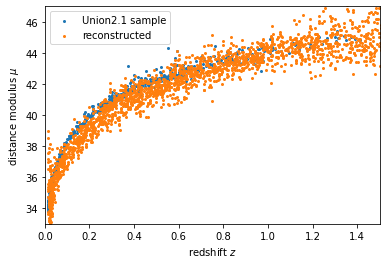

tf.Tensor([[0.45755097 0.2615198  0.2809292 ]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([0], shape=(1,), dtype=int64)


In [8]:
z_mean, z_logvar = encoder(scaler_580.transform(mu.reshape(-1,580))) 
z = vaegan.sampling((z_mean, z_logvar)) # re-parameterize
x_interpolate = generator(z)

plt.scatter(z_obs, mu, s=4, label='Union2.1 sample')
plt.scatter(vaegan.z, scaler.inverse_transform(x_interpolate.numpy()), s=4, label='reconstructed')
plt.xlim(0,1.5)
plt.ylim(33,47)
plt.xlabel(r'redshift $z$')
plt.ylabel(r'distance modulus $\mu$')
plt.legend()
plt.show()

pred = vaegan.s_discriminator(x_interpolate)
print(pred)
print('Class : ',tf.argmax(pred, axis=-1))